## Εθνικό Μετσόβιο Πολυτεχνείο 
## Σχολή Ηλεκτρολόγων Μηχανικών & Μηχανικών Υπολογιστών


### Μάθημα: Στοχαστικές διαδικασίες
### Διδάσκων: Μιχαήλ Λουλάκης
### Ακαδημαϊκό έτος: 2017-2018

### Ιωάννης Κ. Γεωργακόπουλος
### Α.Μ.: 03111512

# 9η Εργαστηριακή Άσκηση

Σε αυτό το εργαστήριο θα εργαστούμε πάνω σε ενδιαφέρουσες εφαρμογές των τεχνικών που μάθαμε στο προηγούμενο.
Στο τέλος μάλιστα, θα κατασκευάσουμε μία προσεγγιστική λύση του προβλήματος του πλανώδιου πωλητή.

Στα πλαίσια του εργαστηρίου θα χρησιμοποιήσουμε τις παρακάτω βιβλιοθήκες.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)  # increase default figure size

np.random.seed(2018)  # for reproducibility

## Άσκηση 1: Προσομοιωμένη Ανόπτηση

Στην άσκηση αυτή θα χρησιμοποιήσουμε τη μέθοδο της προσομοιωμένης ανόπτησης
([simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)) για
να βρουμε το ελάχιστο μιας συνάρτησης $V: \mathbb{R} \to \mathbb{R}$. 
Εν προκειμένω θα μελετήσουμε την πολυωνυμική συνάρτηση:

$$ V(x) = \frac{13}{90} x^4 - \frac{3}{10} x^3 - \frac{101}{45} x^2 \frac{13}{15}x + 4$$

Η γραφική της παράσταση κατασκευάζεται στο παρακάτω κελί.

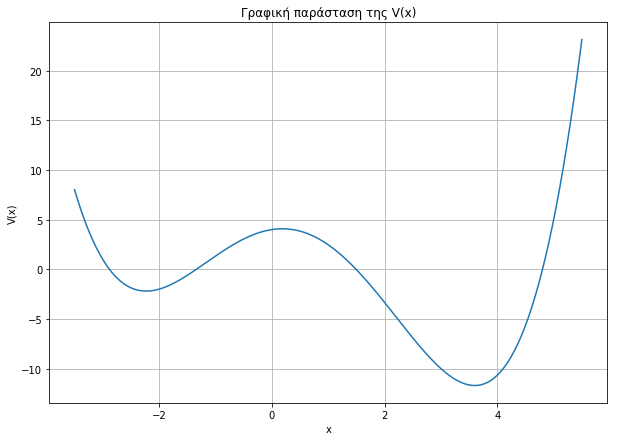

In [2]:
def V(x):
    """Energy (objective) function to minimize"""
    return np.polyval((13/90, -3/10, -101/45, 13/15, 4.0), x)

x = np.linspace(-3.5, 5.5, 1000) #Διαλέγουμε κατάλληλα όρια ώστε να φαίνονται τα ακρότατα της συνάρτησης

plt.figure(figsize = (10, 7))
plt.plot(x, V(x))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title('Γραφική παράσταση της V(x)')
plt.grid(True)
plt.show()

Θα υπολογίσουμε αιτιοκρατικά το τοπικό και ολικό ελάχιστο, ώστε να τα έχουμε ως benchmarks στη συνέχεια.

In [3]:
#np.argmin(V(x))

LocalMin = -2.2293
GlobalMin = 3.60005

Ακολουθεί ο αλγόριθμος Metropolis-Hastings για την στοχαστική προσεγγιστική εύρεση των ελαχίστων.

In [4]:
def sim_anneal(f, x_low, x_high,
               T=2.0, T_min=2**(-12), 
               cool_factor=0.9, cool_sch=100,
               delta = 1.0, shrink_factor=0.5, shrink_thres=0.25,
               trace = False):
    
    # Initialize
    x = np.random.uniform(x_low, x_high)
    f_cur = f(x)  # current value of f
    steps = accepted = 0
    if trace: path = []

    # Main loop
    while T > T_min:
        
        # proposed new position
        x_new = x + np.random.uniform(-delta, delta)
        if x_new > x_high or x_new < x_low:
            continue  # skip this proposal
        f_new = f(x_new)

        # accept/reject jump
        if np.log(np.random.rand()) < -(f_new - f_cur) / T :
            x, f_cur = x_new, f_new
            accepted += 1            
                
        # Cooling
        if steps == cool_sch:  # time for the next cooling
            T *= cool_factor  # cool down
            # Adjust Search Space
            if accepted / steps < shrink_thres:
                delta *= shrink_factor
            steps = accepted = 0
        
        if trace: path.append(x)
        steps += 1        
        
    
    if trace: return path
    return x

Οι παράμετροι της συνάρτησης `sim_anneal` είναι:

* **`f`**: η συνάρτηση που θέλουμε να ελαχιστοποιήσουμε
* **`x_low, x_high`**: Το όρια μέσα στα οποία ψάχνουμε να βρούμε το ελάχιστο
* **`T, T_min`**: Η αρχική και η τελική θερμοκρασία της "ανόπτησης"
* **`cool_factor`**: Πόσο μειώνεται η θερμοκρασία σε κάθε κύκλο ψύξης (ποσοστό της προηγούμενης)
* **`cool_sch`**: Κάθε πόσα βήματα να μειώνεται η θερμοκρασία
* **`delta`**: Ακτίνα από την οποία θα προτείνουμε άλμα
* **`shrink_factor`**: Πόσο θα μειώσουμε το `delta` αν δούμε ότι η μέθοδος έχει κολλήσει
* **`shirnk_thres`**: Ποσοστό το επιτυχημένων αλμάτων κάτω από το οποίο θεωρούμε ότι το σωματίδιο έχει κολλήσει.
* **`trace`**: Αν θέλουμε να μας γυρίσει όλη την διαδρομή ή μόνο την τελική θέση

Επομένως για να βρούμε το ελάχιστο της συνάρτησης $V$ που ορίσαμε προηγουμένως στο
διάστημα $(-3.5, 5.5)$ τρέχουμε την συνάρτηση με τις εξής παραμέτρους.

*Παρατήρηση: Ζητάμε όλο το μονοπάτι του σωματιδίου για να το πλοτάρουμε αργότερα.*

In [5]:
# Parameters
T_start, T_end = 2.0, 2**(-12)
cool_sch, cool_factor = 100, 0.99

path = sim_anneal(V, -3.5, 5.5, delta = 1.,                      
                  T = T_start, T_min = T_end,
                  cool_factor = cool_factor, 
                  cool_sch = cool_sch,
                  trace = True)  # keep the default for the rest, (-3.5,5) ώστε να βρω τα ελάχιστα 

path[-1]  # last position

3.5963735407238038

Το επόμενο κελί κώδικα οπτικοποιεί τη διαδικασία. (Σε pop-up window, όπως στο προηγούμενο)

Διαβάζοντας το source code του animate_simanneal.py, παρατηρήσαμε ότι το πολυώνυμο με το οποίο μας ζητήθηκε να εργαστούμε, λαμβάνεται αν δόσουμε ως όρισμα -minima 2.

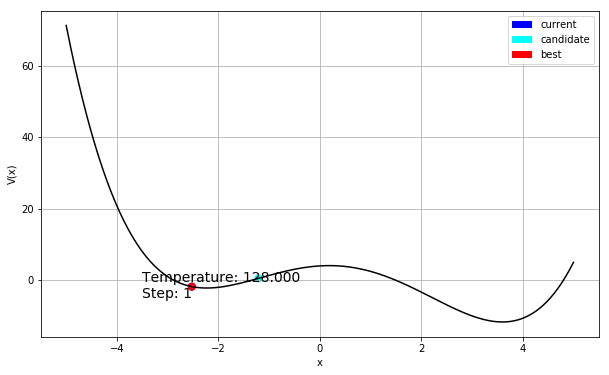

In [6]:
%matplotlib qt
%run ../animate_simanneal.py -minima 2

Στη συνέχεια, τρέχουμε το παρακάτω κελί ώστε τα επόμενα διαγράμματα να εμφανίζονται μέσα στο notebook.

In [7]:
%matplotlib inline

### Ερώτημα Α)

Θα φτιάξουμε ένα loop με 200 επαναλήψεις και θα συγκρίνουμε την τιμή που βρίσκουμε με τα 2 benchmarks κάθε φορά, ώστε να υπολογίσουμε το ποσοστό.

In [8]:
N = 10 # Αρχικοποίηση επαναλήψεων

N_Local  = 0 # Πλήθος output που βρίσκουν το Local Minima
N_Global = 0 # Πλήθος output που βρίσκουν το Global Minima 

for i in range(N):
    path = sim_anneal(V, -3.5, 5, delta = 1.,                      
                  T = T_start, T_min = T_end,
                  cool_factor = cool_factor, 
                  cool_sch = cool_sch,
                  trace = True)  # keep the default for the rest, (-3.5,5) ώστε να βρω τα ελάχιστα 
     
    if abs(path[-1]-LocalMin)<=0.05:
        N_Local  += 1
    if abs(path[-1]-GlobalMin)<=0.05:
        N_Global += 1

print('Ποσοστό εύρεσης κάποιου τοπικού ελαχίστου: ', 100*N_Local/N,'%')
print('Ποσοστό εύρεσης ολικού ελαχίστου:        ', 100*N_Global/N, '%')    

Ποσοστό εύρεσης κάποιου τοπικού ελαχίστου:  0.0 %
Ποσοστό εύρεσης ολικού ελαχίστου:         100.0 %


Παρατηρούμε ότι ο αλγόριθμος βρίσκει με εξαιρετικά μεγάλη πιθανότητα το ολικό ελάχιστο. Αυτό συμβαίνει επειδή ο default cool factor που έχουμε δώσει είναι μεγάλος.

### Ερώτημα Β)

Θα φτιάξουμε μια λίστα με τα cool factors και θα κατασκευάσουμε την λίστα με την πιθανότητα εύρεσης τοπικού ελαχίστου.

In [9]:
new_cool_factor = [0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
Global = np.zeros(len(new_cool_factor), dtype=float)

for j,i in enumerate(new_cool_factor): 

    for w in range(N):
        
        path = sim_anneal(V, -3.5, 5.5, cool_factor= i, trace = True)
        # print(path[-1])

        if abs(path[-1]-GlobalMin)<=0.05:
            Global[j] += 1
    
print(Global/N)

[0.4 0.9 0.7 0.5 0.7 0.7 1.  1. ]


Ακολουθεί ο κώδιξ με το ζητούμενο διάγραμμα.

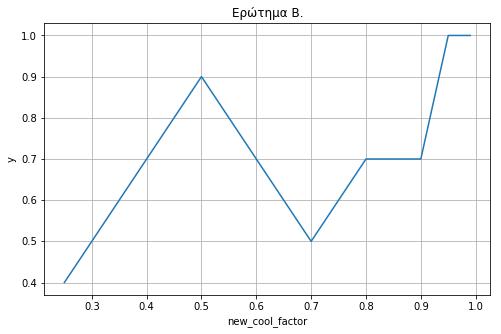

In [10]:
y = Global/N

# Let's plot (x,y)
plt.figure(figsize = (8, 5))
plt.plot(new_cool_factor, y)
# Specify some extra attributes
plt.xlabel('new_cool_factor')
plt.ylabel('y')
plt.title('Ερώτημα Β.')
plt.grid(True)

Τα αποτελέσματα είναι ενδιαφέροντα και ταυτόχρονα αναμενόμενα, καθώς δείχνουν ότι όσο αυξάνουμε τον cool_factor, τα άλματά μας γίνοται μικρότερα άρα και η αναζήτηση γίνεται πιο αυστηρή οπότε βρίσκουμε με μεγαλύτερη πιθανότητα το σωστό ελάχιστο.

##  Άσκηση 2: Πλανόδιος Πωλητής

Στην άσκηση αυτή θα χρησιμοποιήσουμε τον αλγόριθμο της προσομοιωμένης ανόπτησης
για να λύσουμε το πρόβλημα του [πλανόδιου πωλητή](https://en.wikipedia.org/wiki/Travelling_salesman_problem).

Το πρόβλημα έχει ως εξής:

> Ένας πωλητής θέλει να επισκεφτεί $Ν$ πόλεις και να γυρίσει στη βάση του.
Ποια είναι η συντομότερη διαδρομή που ενώνει όλες τις πόλεις;

Στη συγκεκριμένη άσκηση θα ασχοληθούμε με πόλεις της Ευρώπης.
Αρχικά το παρακάτω κελί κώδικα, ώστε να κατεβάσουμε το αρχείο [eu.csv](http://math.ntua.gr/~loulakis/info/python_codes_files/eu.csv) που περιέχει 
το γεωργαφικό μήκος και πλάτος 27 ευρωπαϊκών πόλεων. Ο κώδικας οργανώνει την πληροφορία ως εξής:

* **`city_coord`** ένα `dictionary` που για κάθε πόλη έχει το γεωγραφικό μήκος και πλάτος
* **`Ncities`** ο αριθμός των πόλεων (27)
* **`city_names`** τα ονόματα των πόλεων

Το κελί τυπώνει τις συντεταγμένες της Αθήνας για επαλήθευση.

In [11]:
import csv
import urllib.request

url = "http://math.ntua.gr/~loulakis/info/python_codes_files/eu.csv"
with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())
city_coord["Athens"]

(37.97918, 23.716647)

Στο επόμενο κελί ορίζουμε την συνάρτηση `geodesic_dist` η οποία υπολογίζει την
απόσταση μεταξύ 2 πόλεων δοθέντων των συντεταγμένων τους (credit to [Michael Dunn](http://stackoverflow.com/a/4913653/2167530)) με βάση τον τύπο [Haversine](https://en.wikipedia.org/wiki/Haversine_formula).

In [12]:
def geodesic_dist(city1, city2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    if city1 == city2:
        return 0.
    lon1, lat1 = np.deg2rad(city1)
    lon2, lat2 = np.deg2rad(city2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers 6371. Use 3956 for miles
    return c * r

Για ευκολία και ταχύτητα θα υπολογίσουμε όλες της αποστάσεις εκ των προτέρων και θα τις αποθηκεύσουμε σε ένα πίνακα

In [13]:
# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

Σαν σύμβαση θεωρούμε ότι η αρχική σειρά των πόλεων είναι αυτή με την οποία
μπορούμε να κάνουμε iterate το `city_coord` δηλαδή:

In [14]:
for i, city in enumerate(city_coord): print(i, city)

0 Brussels
1 Vienna
2 Sofia
3 Nicosia
4 Prague
5 Copenhagen
6 London
7 Helsinki
8 Paris
9 Berlin
10 Athens
11 Budapest
12 Reykjavik
13 Rome
14 Riga
15 Luxembourg
16 Monaco
17 Amsterdam
18 Oslo
19 Warsaw
20 Lisbon
21 Bucharest
22 Moscow
23 Edinburgh
24 Belgrade
25 Madrid
26 Stockholm


### Αλγόριθμος

Επειδή ο δρόμος που θα ακολουθήσει ο πωλητής είναι κυκλικός, δεν έχει σημασία
από που θα ξεκινήσει (μόνο ποιες πόλεις θέλει να επισκεφθεί έχει σημασία).
Ως εκ τούτου, "λύση" στο πρόβλημα μας είναι μια λίστα με τη σειρά με την οποία
κάποιος πρέπει να επισκεφθεί τις πόλεις, δεδομένου ότι μετά την τελευταία πόλη
θα επιστρέψει στην αρχική χωρίς να επισκεφθεί άλλη πόλη.

Επομένως, σκοπός μας είναι να χρησιμοποιήσουμε την τεχνική της προσομοιωμένης ανόπτησης για να
"ψάξουμε" τον χώρο των μεταθέσεων της λίστας των πόλεων ώστε να
βρούμε την μετάθεση που δίνει την συνολική απόσταση κοντά στην ελάχιστη δυνατή.

Για να τρέξουμε τον αλγόριθμο της ανόπτησης χρειαζόμαστε 2 στοιχεία:

1. Μια συνάρτηση *ενέργειας*
2. Έναν τρόπο να μεταβαίνουμε σε γειτονικές καταστάσεις

Ως συνάρτηση ενέργειας θα πάρουμε την συνολική απόσταση που διανύει ο πωλητής 
(αυτή που θέλουμε να ελαχιστοποιήσουμε). 
Στο παρακάτω κελί ορίζουμε την συνάρτηση (είσοδος η σειρά με την οποία ο πωλητής επισκέπτεται τις πόλεις):

In [15]:
def total_dist(cities):
    """The total distance covered by the salesman"""
    total = sum(dist[city1][city2] for city1, city2 in zip(cities[:-1], cities[1:]))
    total += dist[cities[-1]][cities[0]] # return to start
    return total

Ως γειτονικές μεταθέσεις, ορίζουμε τις μεταθέσεις που διαφέρουν μόνο σε ένα ζευγάρι πόλεων. 
Επομένως για να κινηθούμε στον χώρο το μεταθέσεων, θα διαλέγουμε τυχαία 2 πόλεις και θα αλλάζουμε
τη θέση τους στη λίστα.

Για να υπολογίσουμε την αλλαγή στην συνολική απόσταση για μια τέτοια αλλαγή,
μπορούμε να προσθέσουμε όλες τις αποστασεις από την αρχή αλλά προφανώς κάτι τέτοιο 
δεν είναι αποδοτικό. Γι' αυτό το λόγο ορίζουμε την συνάρτηση `dist_diff`.
Στην επόμενη ενότητα εξηγούμε την λογική της συνάρτησης, αν δεν την καταλαβαίνετε
μπορείτε απλά να την χρησιμοποιήσετε σαν μαύρο κουτί.

### Κόστος αλλαγής σειράς επίσκεψης

Η αλλαγή της σειράς 2 πόλεων είναι μια τοπική αλλαγή επομένως αρκεί να σκεφτούμε ποιές είναι
συνέπειες αυτές της αλλαγής. *Πόσες αποστάσεις επηρεάζονται συνολικά;*

Θεωρείστε 2 τριάδες πόλεων τυχαία μέσα στη λίστα:

* $A \to B \to C$ και 
* $X \to Y \to Z$

και και χωρίς βλάβη στη γενικότητα θεωρείστε ότι η πόλη $B$ εμφανίζεται
πριν από την $Y$ στη λίστα.

Υπάρχουν 2 περιπτώσεις

1. Γενική περίπτωση $B$ και $Y$ δεν συνορεύουν (δηλαδή $X \not\equiv B$)
2. Ειδική περιπτωση $B$ και $Y$ συνορεύουν (δηλαδή $X \equiv B$)

Στο παρακάτω διάγραμμα φαίνονται οι συνέπειες που θα είχε μια αλλαγή μεταξύ $B$ και $Y$
στις 2 αυτές περιπτώσεις.

![TSP Swap Cases](../tsp_swap.svg)

Στο παρακάτω κελί ορίζουμε την συνάρτηση.

In [16]:
def dist_diff(ABC, XYZ, tour):
    """
    Differnce of total distance traveled if we swap cities B, Y.
    Input: 2 triplets of nodes A, B, C and X, Y, Z.
    """
    # order
    A, B, C = ABC
    X, Y, Z = XYZ
    # cities
    a, b, c = tour[ABC]
    x, y, z = tour[XYZ]
    
    BpY = (B - Y) % len(tour) # to understand the order
    dx = 0
    
    if BpY != -1 % len(tour):  #  B is not X
        dx += dist[x, b] - dist[x, y] + dist[y, c] - dist[b, c]
    if BpY != 1:  # Y is not A
        dx += dist[a, y] - dist[a, b] + dist[b, z] - dist[y, z]

    return dx

### Υλοποίηση

Στο παρακάτω κελί υλοποιούμε τον αλγόριθμο της προσομοιωμένης
ανόπτησης για το πρόβλημα το πλανόδιου πωλητή.

Αρχικά θέτουμε τις παραμέτρους του αλγορίθμου και μερικές μεταβλητές γαι να οπτικοποιήσουμε τα αποτελέσματα. Ο κώδικας είναι σχεδόν ίδιος με την συνάρτηση που δόθηκε προηγουμένως. Μια σημαντική διαφορά είναι ότι τώρα αποθηκεύουμε τη βέλτιστη λύση που έχουμε βρει μέχρι κάθε στιγμή. Αυτό το κάνουμε γιατί με μικρό υπολογιστικό κόστος μπορεί να βρούμε μια καλύτερη διαδρομή την οποία ο αλγόριθμος εξερεύνησε στην πορεία αλλά δεν τερμάτισε σε αυτήν.

In [17]:
# Annealing Parameters
Temp = 10 ** 7
Temp_end = 0.02
cool_factor = 0.95
cool_schedule = 100

# Bookeeping parameters
tour = np.arange(Ncities)  # initial permutation
tour_length = total_dist(tour)  # initial energy level

shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
shortest_tour_length = tour_length  # shortest distance

# To plot later
first_guess = tour_length
running_lengths = []
optimal_lengths = []

# Main loop
while Temp > Temp_end:
    # Constant Temperature Era
    for step in range(cool_schedule):
        # Choose 2 cities to swap
        B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
        ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
        XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

        # Compute the energy diffence  
        diff = dist_diff(ABC, XYZ, tour)
        
        # Decide whether to change state.
        if np.log(np.random.rand()) < -diff / Temp:
            tour[B], tour[Y] = tour[Y], tour[B]
            tour_length += diff
            # Keep track of the optimal tour observed
            if tour_length < shortest_tour_length:
                shortest_tour = np.copy(tour)
                shortest_tour_length = tour_length

        running_lengths.append(tour_length)
        optimal_lengths.append(shortest_tour_length)

    Temp *= cool_factor  # cool down

print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
print('Initial distance:\t%.0f km'  % first_guess)
print('Optimal distance:\t%.0f km'  % shortest_tour_length)

Improvement:	      60%
Initial distance:	60608 km
Optimal distance:	23996 km


### Αποτελέσματα

Παρακάτω πλοτάρουμε την εξέλιξη της τρέχουσας βέλτιστης λύσης κατά την διάρκεια του αλγορίθμου.

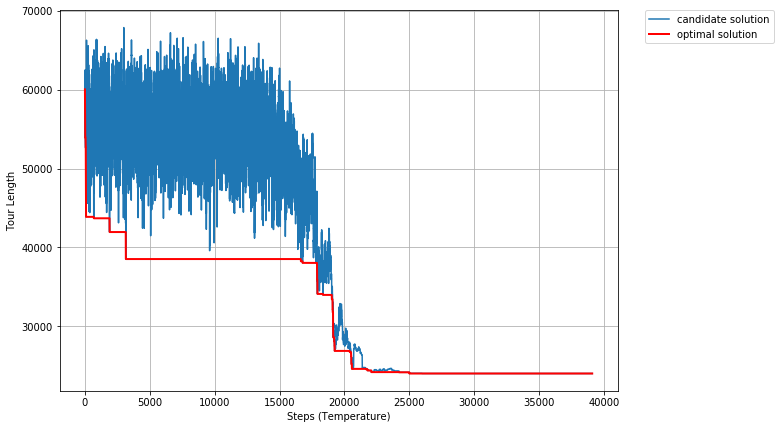

In [18]:
running_lengths = np.array(running_lengths)
optimal_lengths = np.array(optimal_lengths)

plt.figure(figsize = (10, 7))
plt.plot(np.arange(len(running_lengths)), running_lengths, label="candidate solution")
plt.plot(np.arange(len(optimal_lengths)), optimal_lengths, 'r-', linewidth=2, label="optimal solution")

plt.xlabel("Steps (Temperature)")
plt.ylabel("Tour Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

plt.show()

Τέλος, με το επόμενο κελί κώδικα δημιουργούμε μια οπτική αναπαράσταση 
της βέλτιστης διαδρομής.

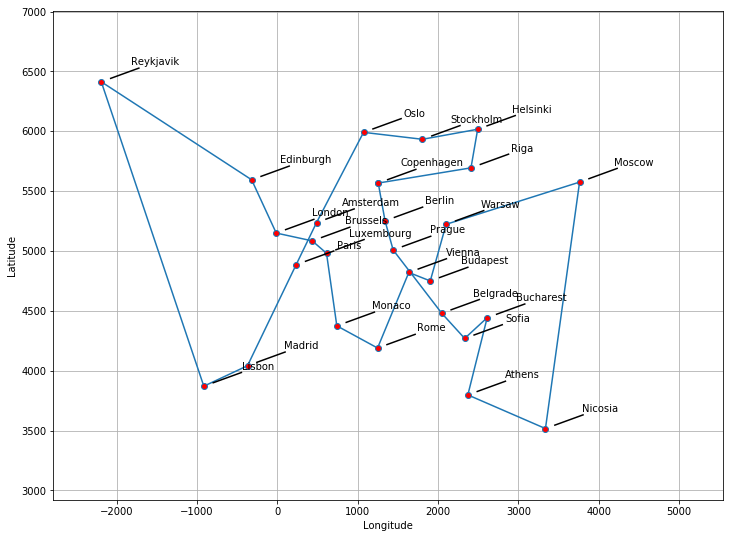

In [19]:
plt.figure(figsize=(12, 9))  # increase image size

# Get Tour Coordinates
coord = np.array([city_coord[city] for city in city_names])
cities = shortest_tour.copy()
cities = np.append(cities, cities[0])
coord = coord[cities,:]  # rearrange

# Scale for better readability
scale_factor = 100
coord = coord * scale_factor

# Plot Tour
plt.plot(coord[:, 1], coord[:,0], 'o-', mfc='r')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

# Manage spacing
spacing = np.fabs(min(coord[:,1]) - max(coord[:,1])) * .1
plt.xlim(min(coord[:,1]) - spacing, max(coord[:,1]) + spacing * 3)
plt.ylim(min(coord[:,0]) - spacing, max(coord[:,0]) + spacing)

# Add labels - remove for more clear picture
if len(cities)<=30:
    for i, city in enumerate(cities[:-1]):
        plt.text(coord[i,1], coord[i,0],
                 '%s' % city_names[city],
                 withdash = True,
                 dashdirection = 1,
                 dashlength = 30,
                 rotation = 0,
                 dashrotation = 20,
                 dashpush = 10)
plt.show()

###  Ερώτημα Α)

Θα προσπαθήσουμε να βελτιώσουμε την λύση πειράζοντας τις παραμέτρους του κώδικα.